In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score
import ta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Data Load, KOSPI200
df = pd.read_excel('D:/XGBoost/data/ks200.xls')
df = df.rename(columns = {'PRE_END'  : 'CLOSE'})
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[['CLOSE']])
df["CLOSE"] = scaled

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [3]:
# Filter to a date similar to the reference
df1= df[df["DATEDEAL"] >= 20091101]
df1= df1[df1["DATEDEAL"] < 20171230]
df1.reset_index(inplace= True)
df = df1
df

In [4]:
# Make Indicator : SMA, EMA, Stochastic K%, Stochastic D%, RSI, MACD, Disparity
def Make_Indicators(df):
    global sma, ema, sto_k, sto_d, rsi, macd, disparity
    
    # SMA
    sma = ta.trend.sma_indicator(df["CLOSE"],12)

    # EMA
    ema = ta.trend.ema_indicator(df["CLOSE"],12)

    # Stochastic
    sto_k = ta.momentum.stochrsi_k(df["CLOSE"])
    sto_d = ta.momentum.stochrsi_d(df["CLOSE"])

    # RSI
    rsi = ta.momentum.rsi(df["CLOSE"], 14)

    # MACD
    macd = ta.trend.macd(df["CLOSE"], 13, 26)

    # Disparity
    df["MA"]=df["CLOSE"].rolling(20).mean()
    disparity = 100*(df["CLOSE"]/df["MA"])

In [5]:
def Concat_ind(dataFrame):
    global x, y

    # Concat Indicators and Price
    x = np.zeros((len(df)-40-1,8))
    idx = 0
    for i in range(40,len(df)-1):
        x[idx][0] = sma[i]
        x[idx][1] = ema[i]
        x[idx][2] = sto_k[i]
        x[idx][3] = sto_d[i]
        x[idx][4] = rsi[i]
        x[idx][5] = macd[i]
        x[idx][6] = disparity[i]
        x[idx][7] = df["CLOSE"][i]
        idx += 1

    # Next Day Close Price
    y = np.zeros((len(df)-40-1,1))
    idx2 = 0
    for j in range(40,len(df)-1):
        y[idx2][0] = df["CLOSE"][j+1]
        idx2 += 1

In [6]:
def Slice_Window(size):
    global X, Y
    X = []
    Y = []
    size = size
    idx = 0
    for i in range(0, len(x)-size+1):
        x_1 = []
        y_1 = []
        for j in range(size):
            x_1.append(x[i+j][0])
            x_1.append(x[i+j][1])
            x_1.append(x[i+j][2])
            x_1.append(x[i+j][3])
            x_1.append(x[i+j][4])
            x_1.append(x[i+j][5])
            x_1.append(x[i+j][6])
            x_1.append(x[i+j][7])
        
        y_1.append(y[i+(size-1)][0])
        X.append(x_1)
        Y.append(y_1)
        
    print(np.shape(X))

In [7]:
Make_Indicators(df)
Concat_ind(df)
Slice_Window(10)

(1969, 80)


In [8]:
# Model Build
model = XGBRegressor(max_depth =5, n_estimators = 300, learning_rate = 0.05)

model.fit(X[:1400], Y[:1400])
y_pred = model.predict(X[1400:])

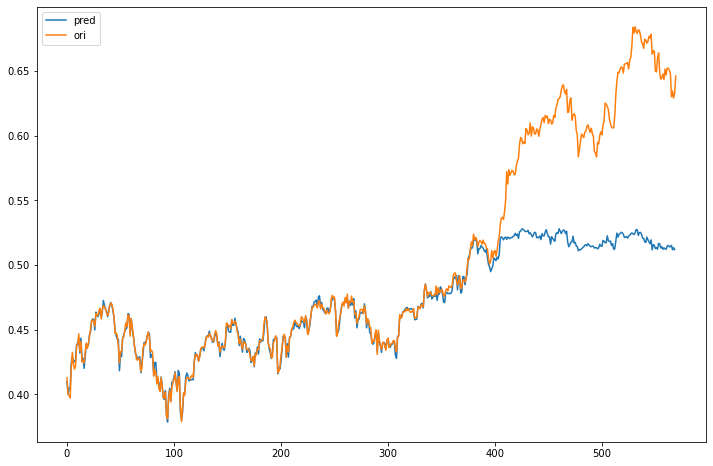

In [10]:
plt.figure(figsize=(12,8))
plt.plot(y_pred, label = 'pred')
plt.plot(Y[1399:], label = 'ori')
plt.legend()

In [17]:
# Check Accuracy
same_count = 0
Y2 = Y[1399:]
for i in range(len(y_pred)):
    if i > 0:
        cha = y_pred[i] - y_pred[i-1]
        cha2 = Y2[i][0] - Y2[i-1][0]
        if cha >= 0 and cha2 >= 0:
            same_count += 1
        if cha < 0 and cha2 < 0:
            same_count += 1

acc = round(same_count / (len(y_pred)-1)*100, 2)
print("Accuracy : {}%".format(acc))

IndexError: list index out of range

In [12]:
# Data Load, Samsung Electronics
df = pd.read_csv('D:/XGBoost/data/Samsung.txt', sep = ',')

In [13]:
Make_Indicators(df)
Concat_ind(df)
Slice_Window(10)

(1425, 80)


In [14]:
# Model Build
model = XGBRegressor(max_depth =5, n_estimators = 300, learning_rate = 0.05)

model.fit(X[:900], Y[:900])
y_pred = model.predict(X[900:])

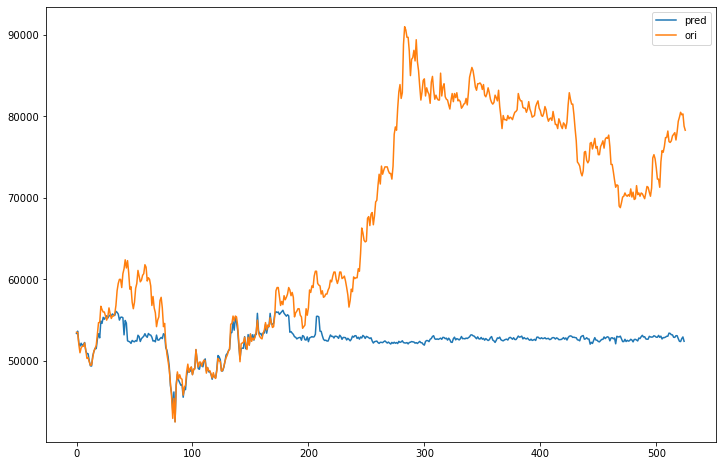

In [19]:
plt.figure(figsize=(12,8))
plt.plot(y_pred, label = 'pred')
plt.plot(Y[899:], label = 'ori')
plt.legend()

In [20]:
# Check Accuracy
same_count = 0
Y2 = Y[899:]
for i in range(len(y_pred)):
    if i > 0:
        cha = y_pred[i] - y_pred[i-1]
        cha2 = Y2[i][0] - Y2[i-1][0]
        if cha >= 0 and cha2 >= 0:
            same_count += 1
        if cha < 0 and cha2 < 0:
            same_count += 1

acc = round(same_count / (len(y_pred)-1)*100, 2)
print("Accuracy : {}%".format(acc))

Accuracy : 59.73%
